# Import essential libs

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.spatial import distance_matrix
import sys
import pulp

sys.path.append("../lib")
from plot import plot_cities_fig

## Cities dataframe

In [2]:
df = pd.read_csv("../data/cities.csv")

## Plotting cities figure

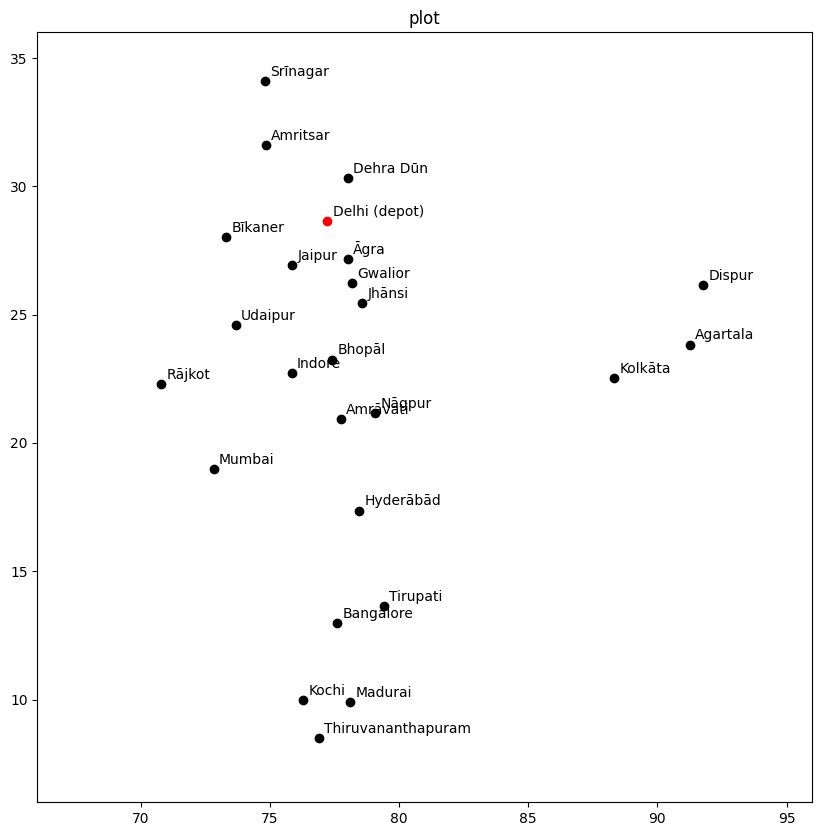

In [3]:
number_of_locs = 25
slice_df = df.copy().head(number_of_locs)
slice_distance = slice_df[["x", "y"]]

matrix = pd.DataFrame(
    distance_matrix(slice_distance.values, slice_distance.values),
    index=slice_distance.index,
    columns=slice_distance.index,
)

plot_cities_fig(slice_df)
plt.show()

## Model

In [4]:
model = pulp.LpProblem("tsp", pulp.LpMinimize)

x = pulp.LpVariable.dicts(
    "x",
    ((i, j) for i in range(number_of_locs) for j in range(number_of_locs)),
    cat="Binary",
)

model += pulp.lpSum(
    matrix[i][j] * x[i, j] for i in range(number_of_locs) for j in range(number_of_locs)
)

for i in range(number_of_locs):
    model += x[i, i] == 0
    model += pulp.lpSum(x[i, j] for j in range(number_of_locs)) == 1
    model += pulp.lpSum(x[j, i] for j in range(number_of_locs)) == 1

status = model.solve()

route = [
    (i, j)
    for i in range(number_of_locs)
    for j in range(number_of_locs)
    if pulp.value(x[i, j]) == 1
]

route

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/codeyan/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/59ba7cf4e2854be4ae74c2e6f61c8791-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/59ba7cf4e2854be4ae74c2e6f61c8791-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 80 COLUMNS
At line 3206 RHS
At line 3282 BOUNDS
At line 3908 ENDATA
Problem MODEL has 75 rows, 625 columns and 1275 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 61.2712 - 0.00 seconds
Cgl0002I 25 variables fixed
Cgl0004I processed model has 50 rows, 600 columns (600 integer (600 of which binary)) and 1200 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 61.2712
Cbc0038I Before mini branch and bound, 600 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did 

[(0, 8),
 (1, 11),
 (2, 10),
 (3, 5),
 (4, 3),
 (5, 4),
 (6, 21),
 (7, 9),
 (8, 0),
 (9, 7),
 (10, 18),
 (11, 1),
 (12, 19),
 (13, 17),
 (14, 24),
 (15, 22),
 (16, 23),
 (17, 13),
 (18, 2),
 (19, 12),
 (20, 14),
 (21, 6),
 (22, 15),
 (23, 16),
 (24, 20)]

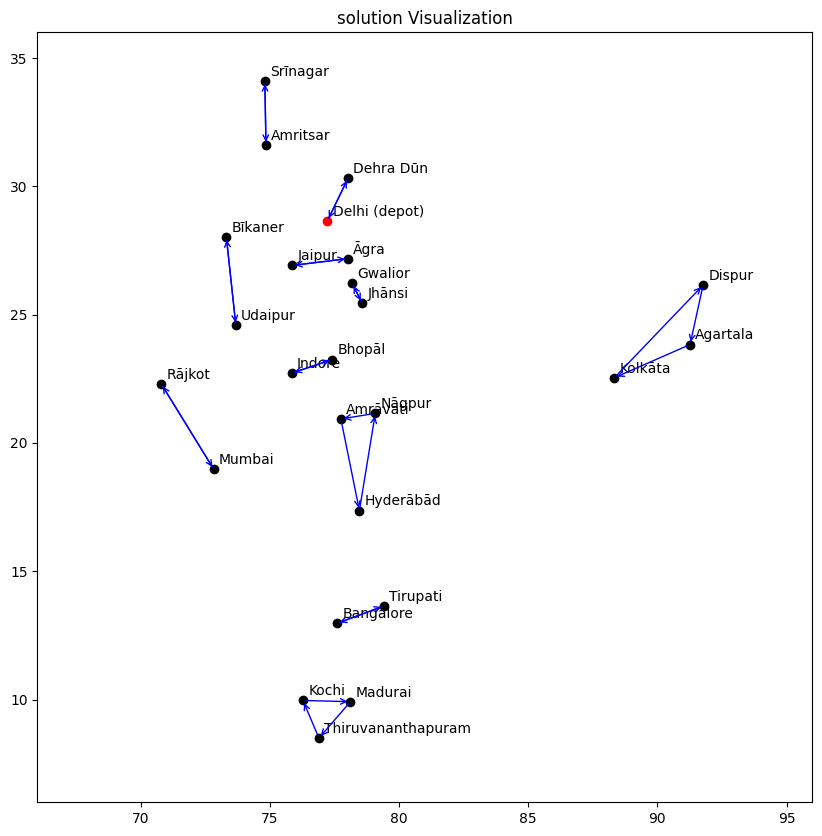

In [5]:
plot_cities_fig(slice_df, heading="solution Visualization")
arrowprops = dict(arrowstyle="->", connectionstyle="arc3", edgecolor="blue")
for i, j in route:
    plt.annotate(
        "",
        xy=[slice_df.iloc[j]["x"], slice_df.iloc[j]["y"]],
        xytext=[slice_df.iloc[i]["x"], slice_df.iloc[i]["y"]],
        arrowprops=arrowprops,
    )

## Fixing subtour with MTZ approach

In [6]:
model = pulp.LpProblem("tsp", pulp.LpMinimize)

x = pulp.LpVariable.dicts(
    "x",
    ((i, j) for i in range(number_of_locs) for j in range(number_of_locs)),
    cat="Binary",
)

t = pulp.LpVariable.dicts(
    "t",
    (i for i in range(number_of_locs)),
    lowBound=1,
    upBound=number_of_locs,
    cat="Continuous",
)

model += pulp.lpSum(
    matrix[i][j] * x[i, j] for i in range(number_of_locs) for j in range(number_of_locs)
)

for i in range(number_of_locs):
    model += x[i, i] == 0
    model += pulp.lpSum(x[i, j] for j in range(number_of_locs)) == 1
    model += pulp.lpSum(x[j, i] for j in range(number_of_locs)) == 1

for i in range(number_of_locs):
    for j in range(number_of_locs):
        if i != j and (i != 0 and j != 0):
            model += t[j] >= t[i] + 1 - (2 * number_of_locs) * (1 - x[i, j])


status = model.solve()

route = [
    (i, j)
    for i in range(number_of_locs)
    for j in range(number_of_locs)
    if pulp.value(x[i, j]) == 1
]

route

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/codeyan/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/b0e06ec6a9cd417f849534c84b3d6e68-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/b0e06ec6a9cd417f849534c84b3d6e68-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 632 COLUMNS
At line 5414 RHS
At line 6042 BOUNDS
At line 6716 ENDATA
Problem MODEL has 627 rows, 649 columns and 2931 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 61.4962 - 0.00 seconds
Cgl0002I 25 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 552 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 552 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 552 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 552 strengthened rows, 0 substitutions
Cgl0

[(0, 8),
 (1, 11),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 15),
 (6, 21),
 (7, 9),
 (8, 7),
 (9, 16),
 (10, 2),
 (11, 24),
 (12, 0),
 (13, 18),
 (14, 20),
 (15, 22),
 (16, 19),
 (17, 13),
 (18, 10),
 (19, 6),
 (20, 17),
 (21, 23),
 (22, 12),
 (23, 1),
 (24, 14)]

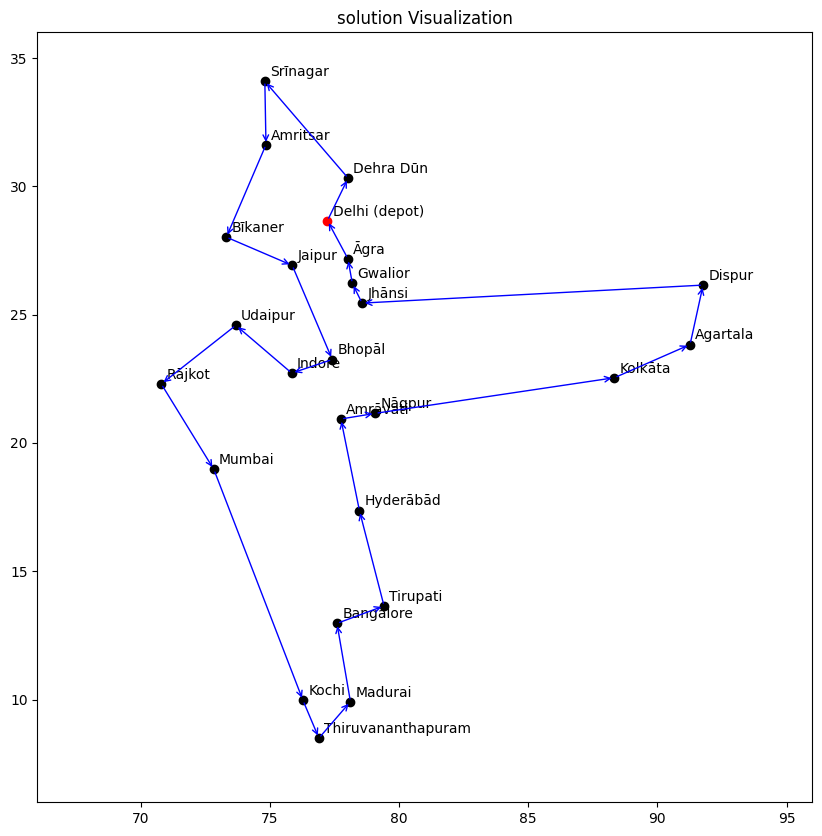

In [7]:
plot_cities_fig(slice_df, heading="solution Visualization")
arrowprops = dict(arrowstyle="->", connectionstyle="arc3", edgecolor="blue")
for i, j in route:
    plt.annotate(
        "",
        xy=[slice_df.iloc[j]["x"], slice_df.iloc[j]["y"]],
        xytext=[slice_df.iloc[i]["x"], slice_df.iloc[i]["y"]],
        arrowprops=arrowprops,
    )